# LATIN HYPERCUBE SAMPLING
Latin hypercube sampling (LHS) is a statistical method for generating a near-random sample of parameter values from a multidimensional distribution. The sampling method is often used to construct computer experiments or for Monte Carlo integration.

To generalize the Latin square to a hypercube, we define a X = (X1, . . . , Xp) as a collection of p independent random variables. To generate N samples, we divide the domain of each Xj in N intervals. In total there are Np such intervals. The intervals are defined by the N + 1 edges:



In [27]:
!pip install -q sobol_seq
!pip install -q ghalton
!pip install -q pyDOE

Created by V.Vijay Kumar Naidu (vvelagal@nd.edu)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
import math
from scipy.stats.distributions import norm
from scipy.stats import gamma
import sobol_seq
import ghalton
from scipy import stats
from pyDOE import *
%matplotlib inline

**Latin-Hper cube 2D**

Makes a Latin Hyper Cube sample and returns a matrix X of size n by 2. For each column of X, the n values are randomly distributed with one from each interval (0,1/n), (1/n,2/n), ..., (1-1/n,1) and they are randomly permuted.

In [10]:
def latin_hypercube_2d_uniform(n):
  lower_limits=np.arange(0,n)/n
  upper_limits=np.arange(1,n+1)/n

  points=np.random.uniform(low=lower_limits,high=upper_limits,size=[2,n]).T
  np.random.shuffle(points[:,1])
  return points

<function matplotlib.pyplot.show>

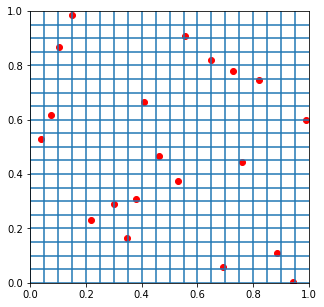

In [15]:
n=20
p=latin_hypercube_2d_uniform(n)
plt.figure(figsize=[5,5])
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(p[:,0],p[:,1],c='r')

for i in np.arange(0,1,1/n):
  plt.axvline(i)
  plt.axhline(i)
plt.show

**Latin-hypercube designs can be created using the following simple syntax**


In [ ]:
lhs(n, [samples, criterion, iterations])

**n**: an integer that designates the number of factors (required).

**samples**: an integer that designates the number of sample points to generate for each factor (default: n)
criterion: a string that tells lhs how to sample the points (default: None, which simply randomizes the points within the intervals):

**“center” or “c”**: center the points within the sampling intervals
“maximin” or “m”: maximize the minimum distance between points, but place the point in a randomized location within its interval

**“centermaximin” or “cm”**: same as “maximin”, but centered within the intervals

**“correlation” or “corr”**: minimize the maximum correlation coefficient

The output design scales all the variable ranges from zero to one which can then be transformed as the user wishes (like to a specific statistical distribution using the scipy.stats.distributions ppf (inverse cumulative distribution) function

In [10]:
>>> from scipy.stats.distributions import norm
from pyDOE import *
>>> lhd = lhs(2, samples=5)
>>> lhd = norm(loc=0, scale=1).ppf(lhd)  # this applies to both factors here

Graphically, each transformation would look like the following, going from the blue sampled points (from using lhs) to the green sampled points that are normally distributed: (Adapted from https://pythonhosted.org/pyDOE/randomized.html)


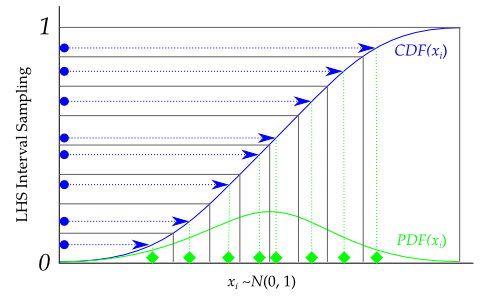

An example for Latin-Hyper cube sampling

In [8]:
design = lhs(4, samples=10)
>>> from scipy.stats.distributions import norm
>>> means = [1, 2, 3, 4]
>>> stdvs = [0.1, 0.5, 1, 0.25]
>>> for i in range(4):
...     design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])
...
>>> design


array([[0.97456505, 1.56630111, 4.39913311, 4.27057037],
       [0.82942467, 2.70738743, 2.75440401, 3.5993837 ],
       [0.93903332, 1.35855932, 3.02364834, 3.84156867],
       [1.07748205, 2.30618755, 1.28819392, 3.93077869],
       [1.12947813, 2.25734753, 3.64860592, 4.19002984],
       [1.01880525, 2.5369553 , 2.38106717, 3.94225274],
       [1.10765369, 1.79526801, 3.98229725, 4.07709038],
       [0.98640517, 1.71421093, 2.55878826, 3.74585775],
       [1.04364073, 1.94010575, 1.72636217, 4.06010393],
       [0.88713426, 2.06695659, 3.26470336, 4.56878509]])

**Set up diffusion reaction equation**

The steady advection-diffusion-reaction(ADR) equation in one-spatial dimension with a spatially constant, but uncertain, diffusion coefficient, a linear reaction term, and a prescribed uncertain source.

$$
\nu \frac{du}{dx} - \omega \frac{d^2u}{dx^2} + \kappa(x)u = S(x)
$$
The QoI is total reaction rate:$$
Q= \int^{10}_{0} \kappa(x_ u)u(x)dx
$$
where v and ω are spatially constant with means
$$
\nu = 10, μ_{ω} = 20, 
$$
and
$$
Var(v) = 0.0723493, Var(ω) = 0.3195214.
$$

The reaction coefficient, κ(x), is  given by 
$$
κ(x) = κ_{l}  \space   x ∈ (5, 7.5)
$$ 
       $$  \space    κ_{h} \space otherwise$$ 
    
  The value of the source is given by
$$S(x) = qx(10 − x),$$ 

In [15]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    #Solves the diffusion equation with Generalized Source
    A = sparse.dia_matrix((Nx,Nx),dtype="complex")
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx + kappa)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    #solve A x = Source
    Solution = linalg.spsolve(A.tocsr(),Source)
    Q = integrate.trapz(Solution*kappa,dx=dx)
    return Solution, Q

Solve diffusion equation

[10. 10. 10. ... 10. 10. 10.]
(52.390252927703344+0j)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


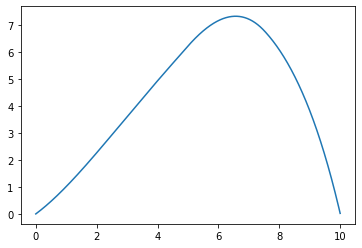

In [16]:
Lx = 10
Nx = 2000
dx = Lx/Nx
Source_func = lambda x, q:  q*x*(10-x)
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>5)*(x<7.5)
v_func = lambda x,v: v*np.ones(x.size)
omega_func = lambda x,omega: omega*np.ones(x.size)

#nominal values

import csv

xs = np.linspace(dx/2,Lx-dx/2,Nx)
source = Source_func(xs, 1)
kappa = kappa_func(xs, 0.1, 2)

omega_nom = 20
omega_var = 0.3195214
v_nom = 10
v_var = 0.0723493
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
vs = v_func(xs, v_nom)
print(vs)
sol,Q = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs, kappa)
print(Q)
plt.plot(xs,sol)
plt.show()

We are going to join gamma RVs with a normal copula. First we get the normal samples

In [17]:
means = [v_nom, omega_nom, kappal_nom, kappah_nom, q_nom]
varmat = np.zeros((5,5))
#fill in diagonal
corrmat = np.ones((5,5))
corrmat[0,:] = (1,.1,-0.05,0,0)
corrmat[1,:] = (.1,1,-.4,.3,.5)
corrmat[2,:] = (-0.05,-.4,1,.2,0)
corrmat[3,:] = (0,.3,0.2,1,-.1)
corrmat[4,:] = (0,.5,0,-.1,1)
print(corrmat-corrmat.transpose())
print(corrmat)


varmat[np.diag_indices(5)] = [v_var, omega_var, kappal_var, kappah_var, q_var]
for i in range(5):
    for j in range(5):
        varmat[i,j] = math.sqrt(varmat[i,i])*math.sqrt(varmat[j,j])*corrmat[i,j]
print(varmat)
print(varmat-varmat.transpose())
print(np.linalg.eig(varmat))

samps = 10**6 #4*10**4
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))

print(np.max(test[:,0]))
import tabulate
#print(tabulate.tabulate(corrmat, tablefmt="latex", floatfmt=".2f"))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[ 1.    0.1  -0.05  0.    0.  ]
 [ 0.1   1.   -0.4   0.3   0.5 ]
 [-0.05 -0.4   1.    0.2   0.  ]
 [ 0.    0.3   0.2   1.   -0.1 ]
 [ 0.    0.5   0.   -0.1   1.  ]]
[[ 7.23493000e-02  1.52043249e-02 -3.92366580e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.52043249e-02  3.19521400e-01 -6.59651879e-04  8.93816670e-03
   7.51094687e-03]
 [-3.92366580e-05 -6.59651879e-04  8.51157000e-06  3.07547395e-05
   0.00000000e+00]
 [ 0.00000000e+00  8.93816670e-03  3.07547395e-05  2.77814200e-03
  -1.40072194e-04]
 [ 0.00000000e+00  7.51094687e-03  0.00000000e+00 -1.40072194e-04
   7.06235300e-04]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(array([3.20880078e-01, 7.14248146e-02, 2.58516363e-03, 4.68396801e-04,
       5.13602871e-06]), array([[-6.10221850e-02, -9.98104846e-01, -5.23689494e-03,
         5.95871096e-03,  2.80458596e-04],
       [-9.97466874e-01,  6

The distributions will be gammas

In [18]:
def gen_samps(samps,test):
    #v will have v_nom = 10 v_var = 1 which makes alpha = 10 beta = 10 or theta = 1/10
    vsamps = gamma.ppf(test[:,0], a = 100, scale = 1/10)
    #print(np.mean(vsamps), np.var(vsamps), np.std(vsamps))
    #plt.hist(vsamps)

    #omega will have  omega_nom = 20, var = 4 which makes alpha = 100 beta = 5, theta = 1/5
    omegasamps = gamma.ppf(test[:,1], a = 100, scale = 1/5)
    #print(np.mean(omegasamps), np.var(omegasamps), np.std(omegasamps))
    #plt.hist(omegasamps)

    #kappa_l will have kappa_l = 0.1 var = (0.01)^2 this makes alpha = 100 and theta = 1/1000
    kappalsamps = gamma.ppf(test[:,2], a = 100, scale = 1/1000)
    #print(np.mean(kappalsamps), np.var(kappalsamps), np.std(kappalsamps))
    #plt.hist(kappalsamps)

    #kappa_h will have kappa_h = 2 var = .04 this makes alpha = 100 and theta = 1/50
    kappahsamps = (test[:,3]>0.005)*(1.98582-4.82135) + (4.82135) # #gamma.ppf(test[:,3], a = 100, scale = 1/50)
    print(np.mean(kappahsamps), np.var(kappahsamps), np.std(kappahsamps))
    #plt.hist(kappahsamps)

    #q will have q = 1 var = 0.01 this makes alpha = 100 and theta = 1/100
    qsamps = gamma.ppf(test[:,4], a = 100, scale = 1/100)
    #print(np.mean(qsamps), np.var(qsamps),np.std(qsamps))
    #plt.hist(qsamps)
    
    return vsamps,omegasamps,kappalsamps,kappahsamps,qsamps
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

var_list = [vsamps,omegasamps,kappalsamps,kappahsamps,qsamps]
cormat_emp = np.zeros((5,5))
tmp = np.vstack((var_list[0],var_list[1],var_list[2],var_list[3],var_list[4]))
cormat_emp = np.cov(tmp)
sens = np.array([-1.74063875491,-0.970393472244,13.1587256647,17.7516305655,52.3902556893])
print(cormat_emp, np.dot(sens,np.dot(cormat_emp,sens)))

1.9998757222099997 0.03965785867127662 0.1991428097403384
[[ 9.99844147e-01  2.00171547e-01 -4.98930269e-04  1.20828909e-04
   1.53687357e-05]
 [ 2.00171547e-01  4.00724223e+00 -7.94561030e-03 -2.29630698e-02
   1.00411870e-01]
 [-4.98930269e-04 -7.94561030e-03  9.95114540e-05 -7.64563494e-05
  -1.63072191e-06]
 [ 1.20828909e-04 -2.29630698e-02 -7.64563494e-05  3.96578983e-02
   4.74073446e-04]
 [ 1.53687357e-05  1.00411870e-01 -1.63072191e-06  4.74073446e-04
   1.00233432e-02]] 39.14548906685795


In [19]:
Qs = np.zeros(samps)
print(np.mean(vsamps),np.mean(omegasamps),np.mean(kappalsamps), np.mean(kappahsamps),np.mean(qsamps))
for i in range(samps):
    sol,Qs[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))


10.001031943162694 19.999297746210576 0.10000994959184574 1.9998757222099997 1.0000097438390896


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


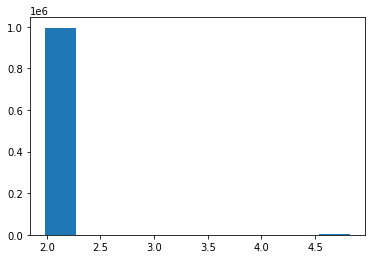

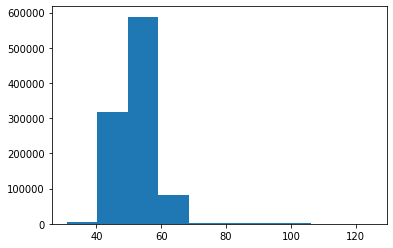

52.31292159923654 60.80399055798508 44.21583930025348 5.7604803915145135 14.30426543122639 2.0153117592678513


In [20]:
plt.hist(kappahsamps)
plt.show()
plt.hist(Qs)
plt.show()
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))
Qref = Qs.copy()
np.savetxt(fname="ref_"+ str(samps) + "_binomial.csv", delimiter=",", X=Qref)

Now we will do 100 samples and compare

In [21]:
samps = 100 #4*10**4
print (samps)
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

100
1.9858199999999997 4.930380657631324e-32 2.220446049250313e-16


In [22]:
QSRS = np.zeros(samps)
for i in range(samps):
    sol,QSRS[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


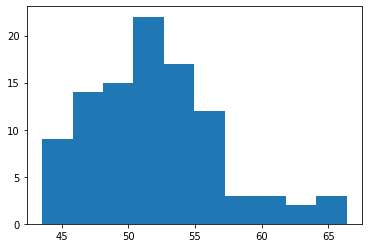

52.00799409339454 61.70948632602295 45.197517605339556 4.745430830870469 0.7124665541617765 0.7291175005695416


In [23]:
plt.hist(QSRS)
plt.show()
print(np.mean(QSRS),stats.scoreatpercentile(QSRS,95),stats.scoreatpercentile(QSRS,5),np.std(QSRS), 
      stats.kurtosis(QSRS), stats.skew(QSRS))

# Application of LHS to advection-reaction-diffusion equation

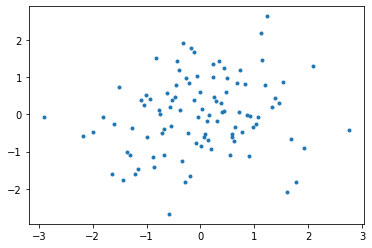

In [24]:
#lhd will have the values in 0 to 1
lhd = lhs(5, samples=samps)
#now i need to turn these into samples from N(0,Corrmat)
#do cholesky fact
chol = np.linalg.cholesky(corrmat)

lhs_unif = np.zeros((samps,5))
for i in range(samps):
    lhs_unif[i,:] = np.dot(chol,norm.ppf(lhd[i,:]))
#print(lhs_unif)
#plt.plot(lhd[:,0],lhd[:,1],'.')
#plt.show()
plt.plot(lhs_unif[:,0],lhs_unif[:,1],'.')
plt.show()

In [25]:
test_lhs = norm.cdf(lhs_unif)

vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_lhs)

1.9858199999999997 4.930380657631324e-32 2.220446049250313e-16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


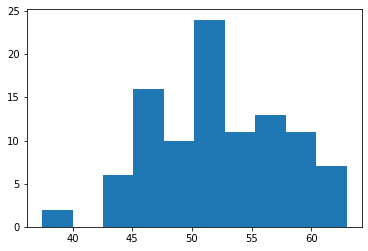

52.1425311302623 61.09950947526438 44.67629854699532 5.353128572938959 -0.49767468464763764 -0.054917191221359914
52.31292159923654 60.80399055798508 44.21583930025348 5.7604803915145135 14.30426543122639 2.0153117592678513


In [26]:
QLHS = np.zeros(samps)
for i in range(samps):
    sol,QLHS[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))
plt.hist(QLHS)
plt.show()
print(np.mean(QLHS),stats.scoreatpercentile(QLHS,95),stats.scoreatpercentile(QLHS,5),np.std(QLHS), 
      stats.kurtosis(QLHS), stats.skew(QLHS))
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))

![alt text](https://drive.google.com/uc?export=view&id=1kojR4my2rsD0hRLKG29ugGT7dLbHkb9h)


